In [2]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [71]:
# unzip files 
path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [72]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

1500
1500


In [73]:
# make directories for cats and dogs
try:
    directory = '/tmp/cats-v-dogs/'
    os.mkdir(directory)
    traindir = os.path.join(directory, 'training/')
    testdir = os.path.join(directory, 'testing/')
    os.mkdir(traindir)
    os.mkdir(testdir)
    os.mkdir(os.path.join(traindir, 'cats/'))
    os.mkdir(os.path.join(traindir, 'dogs/'))
    os.mkdir(os.path.join(testdir, 'cats/'))
    os.mkdir(os.path.join(testdir, 'dogs/'))
except OSError:
    pass

In [74]:
# copy files from source to train and test folders
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source = os.listdir(SOURCE)
    train_copy = random.sample(source, int(0.9 * len(source)))
    for samp in train_copy: 
        PATH = os.path.join(SOURCE, samp)
        if os.path.getsize(PATH) != 0:
            copyfile(PATH, TRAINING + samp)
    test_copy = list(set(source) - set(train_copy))
    for samp in test_copy:
        PATH = os.path.join(SOURCE, samp)
        if os.path.getsize(PATH) != 0:
            copyfile(PATH, TESTING + samp)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [75]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

1350
1350
150
150


In [77]:
# build model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [78]:
# define data loader 
TRAINING_DIR = traindir
train_datagen = ImageDataGenerator(rescale = 1/255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size = 10,
                                                   class_mode = 'binary',
                                                   target_size = (150, 150))

VALIDATION_DIR = testdir
validation_datagen = ImageDataGenerator(rescale = 1/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size = 10,
                                                             class_mode = 'binary',
                                                             target_size = (150, 150))

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [79]:
# train the model 
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/2
270/270 [==============================] - 36s 132ms/step - loss: 0.6977 - acc: 0.5900 - val_loss: 0.7032 - val_acc: 0.5500
Epoch 2/2
270/270 [==============================] - 31s 116ms/step - loss: 0.5933 - acc: 0.6944 - val_loss: 0.5731 - val_acc: 0.7133


Text(0.5, 1.0, 'Training and validation loss')

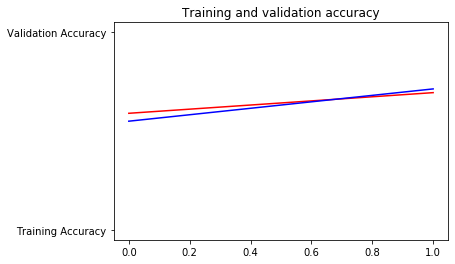

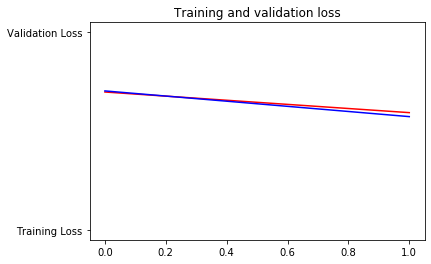

In [80]:
# analyze loss and accuracy
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')